In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import sys
import re
sys.path.append('../')

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor
from tensorflow_tts.models import TFParallelWaveGANGenerator,TFMelGANGenerator, TFPQMF
import torch
from parallel_wavegan.models import ParallelWaveGANGenerator
from tensorflow_tts.configs import ParallelWaveGANGeneratorConfig, MultiBandMelGANGeneratorConfig
import IPython.display as ipd
from num2words import num2words

In [221]:
def replace_words(text,dictionary):
    for key in dictionary.keys():
        text = text.replace(key, dictionary[key])
    return text

conversion_dict = {
    '%' : ' porcento',
    'PSOL': 'pêssól',
    'OAB': 'Oabê',
    'SP': 'São Paulo',
    'RJ': 'Rio de Janeiro',
    '°C': ' graus célsius',
    'ºC': ' graus célsius',
    'Globoplay': 'Globoplei',
    'g1': 'gê um',
    'William Bonner': 'úilliam bôner',
    'll': 'l',
    'e/ou': 'e- ou-',
    'pretos': 'prêtos'
    
}
def convert_helper(obj):
    num_in_text = int(obj.group(0))
    return num2words(num_in_text,lang='pt_BR').replace(",","")

def convert_numbers(text):
    return re.sub(r'\d+',convert_helper,text)

In [222]:
acronym_translation = {
    'A': 'a',
    'B': 'bê',
    'C': 'cê',
    'D': 'dê',
    'E': 'é',
    'F': 'éfe',
    'G': 'gê',
    'H': 'agá',
    'I': 'I',
    'J': 'jóta',
    'K': 'cá',
    'L': 'éle',
    'M': 'ême',
    'N': 'êne',
    'O': 'ó',
    'P': 'pê',
    'Q': 'quê',
    'R': 'érre',
    'S': 'ésse',
    'T': 'tê',
    'U': 'u',
    'V': 'vê',
    'W': 'dábliu',
    'X': 'xis',
    'Y': 'ípsilon',
    'Z': 'zê'
}
def convert_helper_acronym(obj):
    acronym = obj.group(0)
    final_text = ''
    for letter in acronym:
        final_text += acronym_translation[letter] + ' '
    return final_text[:-1]

def convert_acronyms(text):
    return re.sub(r"\b[A-Z]{2,}\b",convert_helper_acronym,text)

In [223]:
def normalize_text(input_text,dictionary):
    output_text = replace_words(input_text,dictionary)
    output_text = convert_numbers(output_text)
    output_text = convert_acronyms(output_text)
    return output_text

In [196]:
normalize_text('g1.',conversion_dict)

'gê um.'

In [197]:
processor = AutoProcessor.from_pretrained("/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/dump_ljspeech/ljspeech_mapper.json")

In [198]:
cfg = AutoConfig.from_pretrained('/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/examples/fastspeech2/conf/fastspeech2.v1.yaml')
fastspeech2 = TFAutoModel.from_pretrained("/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/model-200000.h5",cfg)

In [199]:

tf_model = TFParallelWaveGANGenerator(config=ParallelWaveGANGeneratorConfig(), name="parallel_wavegan_generator")
tf_model._build()
torch_checkpoints = torch.load("/mnt/c/Users/pedro/Documents/TTS/serve-tts/models/p-wavegan-base.pkl", map_location=torch.device('cpu'))
torch_generator_weights = torch_checkpoints["model"]["generator"]
torch_model = ParallelWaveGANGenerator()
torch_model.load_state_dict(torch_checkpoints["model"]["generator"])
torch_model.remove_weight_norm()
def convert_weights_pytorch_to_tensorflow(weights_pytorch):
    """
    Convert pytorch Conv1d weight variable to tensorflow Conv2D weights.
    1D: Pytorch (f_output, f_input, kernel_size) -> TF (kernel_size, f_input, 1, f_output)
    2D: Pytorch (f_output, f_input, kernel_size_h, kernel_size_w) -> TF (kernel_size_w, kernel_size_h, f_input, 1, f_output)
    """
    if len(weights_pytorch.shape) == 3: # conv1d-kernel
        weights_tensorflow = np.transpose(weights_pytorch, (0,2,1))  # [f_output, kernel_size, f_input]
        weights_tensorflow = np.transpose(weights_tensorflow, (1,0,2))  # [kernel-size, f_output, f_input]
        weights_tensorflow = np.transpose(weights_tensorflow, (0,2,1))  # [kernel-size, f_input, f_output]
        return weights_tensorflow
    elif len(weights_pytorch.shape) == 1: # conv1d-bias
        return weights_pytorch
    elif len(weights_pytorch.shape) == 4: # conv2d-kernel
        weights_tensorflow = np.transpose(weights_pytorch, (0,2,1,3))  # [f_output, kernel_size_h, f_input, kernel_size_w]
        weights_tensorflow = np.transpose(weights_tensorflow, (1,0,2,3))  # [kernel-size_h, f_output, f_input, kernel-size-w]
        weights_tensorflow = np.transpose(weights_tensorflow, (0,2,1,3))  # [kernel_size_h, f_input, f_output, kernel-size-w]
        weights_tensorflow = np.transpose(weights_tensorflow, (0,1,3,2))  # [kernel_size_h, f_input, kernel-size-w, f_output]
        weights_tensorflow = np.transpose(weights_tensorflow, (0,2,1,3))  # [kernel_size_h, kernel-size-w, f_input, f_output]
        weights_tensorflow = np.transpose(weights_tensorflow, (1,0,2,3))  # [kernel-size_w, kernel_size_h, f_input, f_output]
        return weights_tensorflow

torch_weights = []
all_keys = list(torch_model.state_dict().keys())
all_values = list(torch_model.state_dict().values())

idx_already_append = []

for i in range(len(all_keys) -1):
    if i not in idx_already_append:
        if all_keys[i].split(".")[0:-1] == all_keys[i + 1].split(".")[0:-1]:
            if all_keys[i].split(".")[-1] == "bias" and all_keys[i + 1].split(".")[-1] == "weight":
                torch_weights.append(convert_weights_pytorch_to_tensorflow(all_values[i + 1].cpu().detach().numpy()))
                torch_weights.append(convert_weights_pytorch_to_tensorflow(all_values[i].cpu().detach().numpy()))
                idx_already_append.append(i)
                idx_already_append.append(i + 1)
        else:
            if i not in idx_already_append:
                torch_weights.append(convert_weights_pytorch_to_tensorflow(all_values[i].cpu().detach().numpy()))
                idx_already_append.append(i)

In [200]:
config_mb_melgan_path = '/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/examples/multiband_melgan_hf/conf/multiband_melgan_hf.lju.v1ft.yml'
with open(config_mb_melgan_path) as f:
        config = yaml.load(f, Loader=yaml.Loader)
mb_melgan = TFMelGANGenerator(
        config=MultiBandMelGANGeneratorConfig(**config["multiband_melgan_generator_params"]),
        name="multiband_melgan_generator",
    )
mb_melgan._build()
mb_melgan.load_weights('/mnt/c/Users/pedro/Documents/TTS/TensorFlowTTS/generator-588000.h5')
pqmf = TFPQMF(
        config=MultiBandMelGANGeneratorConfig(**config["multiband_melgan_generator_params"]), name="pqmf"
    )

In [224]:
from num2words import num2words
input_text = "O Banco Central do Brasil tem seis dicas para ajudar a identificar se uma nota é verdadeira ou falsa. As dicas passam por elementos gráficos e físicos da célula, como uma marca d’água e um relevo em partes específicas."
input_text = normalize_text(input_text,conversion_dict)
print(input_text)
input_ids = processor.text_to_sequence(input_text)

O Banco Central do Brasil tem seis dicas para ajudar a identificar se uma nota é verdadeira ou falsa. As dicas passam por elementos gráficos e físicos da célula, como uma marca d’água e um relevo em partes específicas.


In [225]:
mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32)
)

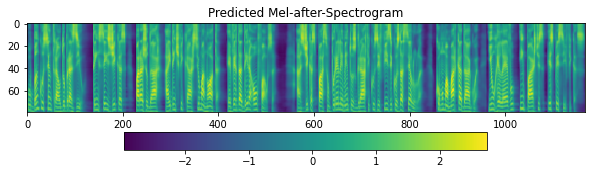

In [226]:
mel_after = tf.reshape(mel_after, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_after), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

In [227]:
tf_var = tf_model.trainable_variables
for i, var in enumerate(tf_var):
    tf.keras.backend.set_value(var, torch_weights[i])
audio = tf_model(tf.expand_dims(mel_after,axis=0))[0, :, 0]
ipd.Audio(audio.numpy(),rate=22050)

In [228]:
import noisereduce as nr
reduced_noise = nr.reduce_noise(y=audio.numpy(), sr=22050,prop_decrease=0.9)
ipd.Audio(reduced_noise,rate=22050)

In [229]:
generated_subbands = mb_melgan(mel_after[None,...])
generated_audios = pqmf.synthesis(generated_subbands)

# convert to numpy.
generated_audios = generated_audios.numpy()  # [B, T]
generated_audios.shape

(1, 597504, 1)

In [230]:
ipd.Audio(generated_audios[0,:,0],rate=44100)

In [231]:
import noisereduce as nr
reduced_noise = nr.reduce_noise(y=generated_audios[0,:,0], sr=44100,prop_decrease=0.3)
ipd.Audio(reduced_noise,rate=44100)

In [235]:
audio.numpy().shape[0]*2

597504

# Let inference other input to check dynamic shape

In [209]:
input_text = "The Commission further recommends that the Secret Service coordinate its planning as closely as possible with all of the Federal agencies from which it receives information."
input_ids = processor.text_to_sequence(input_text)

In [11]:
mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
    energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32)
)

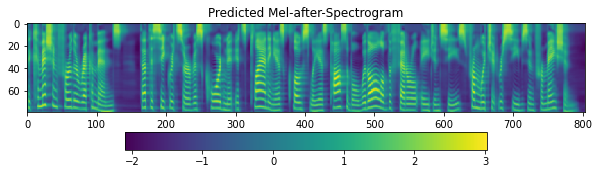

In [12]:
mel_after = tf.reshape(mel_after, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_after), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()